[참고](https://github.com/rickiepark/handson-ml2/blob/master/08_dimensionality_reduction.ipynb)

특성을 너무 많이 가지고 있으면 훈련에도 시간이 많이 걸리고 좋은 솔루션을 찾기 어렵다.

그럴 때 특성 수를 줄여서 가능한 범위로 바꿔주면 되는데,

이런 식으로 차원을 축소시키면 일부 정보가 유실될 수 있음을 주의하자.

또한 차원 축소는 데이터 시각화에도 유용하다.

# 8.1 차원의 저주

훈련 세트의 차원이 클수록 과대적합 위험이 커진다.



# 8.2 차원 축소를 위한 접근 방법

## 8.2.1 투영

대부분의 훈련 샘플이 고차원 공간 안의 저차원 subspace에 놓여 있음.

subspace가 평면인 경우도 있지만, 스위스 롤(Swiss roll)처럼 뒤틀리거나 휘어있기도 함.

이런 경우에는 뒤틀리거나 휘어있는 것을 펼처서 데이터셋을 얻는 게 중요.

## 8.2.2 매니폴드 학습

- 2D **매니폴드** : 고차원 공간에서 휘어지거나 뒤틀린 2D 모양. ex) 스위스 롤
- $d$차원 매니폴드 : $d$차원 초평면으로 보일 수 있는 $n$차원 공간의 일부($n>d$). ex) 스위스 롤 : $d=2$, $n=3$

실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정(manifold assumption) 또는 매니폴드 가설(manifold hypothesis)에 근거하여 매니폴드를 모델링하는 식으로 작동한다.

모델을 훈련시키기 전에 훈련 세트의 차원을 감소시켰을 때 더 나은 솔루션이 되는지를 확인해야 한다.

# 8.3 PCA

- 주성분 분석(principal component analysis, PCA) : 데이터에 가장 가까운 초평면(hyperplane)을 정의한 다음 데이터를 이 평면에 투영시킨다.

## 8.3.1 분산 보존

분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적이다.

즉, 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축을 선택한다.

## 8.3.2 주성분

PCA의 작동 방법
1. 훈련 세트에서 분산이 최대인 축을 찾는다.
2. 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾는다.
3. 이전의 두 축에 직교하고 남은 분산을 최대한 보존하는 세 번째 축을 찾는다.
4. 반복해서 같은 방법으로 축을 찾는다.

$i$번째 축을 이 데이터의 $i$번째 **주성분**(principal component, PC)이라고 한다.

In [1]:
#3D data set 만들기
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3)) #np.empty : uninitialize 된 임의의 array를 제공.
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA는 데이터셋의 평균이 0이라고 가정하므로 만약 직접 구현한다면 데이터를 원점에 맞추는 작업을 해주어야 함.

## 8.3.3 d차원으로 투영하기

In [3]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## 8.3.4 사이킷런 사용하기

In [4]:
# PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_.T[:, 0]

array([-0.93636116, -0.29854881, -0.18465208])

## 8.3.5 설명된 분산의 비율

**설명된 분산의 비율**(exlained variance ratio) : 주성분의 축을 따라 있는데이터 셋의 분산 비율

In [6]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

첫 번째에 84.2%, 두 번째에 14.6%, 세 번째에는 1.2% 미만이므로 무시 가능.

## 8.3.6 적절한 차원 수 선택하기

차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산

In [7]:
# MNIST data set 이용
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [8]:
from sklearn.model_selection import train_test_split

X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) #cumultative sum
d = np.argmax(cumsum >= 0.95) + 1 #np.argmax : max값이 몇번째에 있는지 (0, 1, 2, ...)

In [10]:
# n_components=d로 설정해서 PCA를 다시 실행(주성분 수 지정보다는 컴포넌트 지정이 더 나음).
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [11]:
d

154

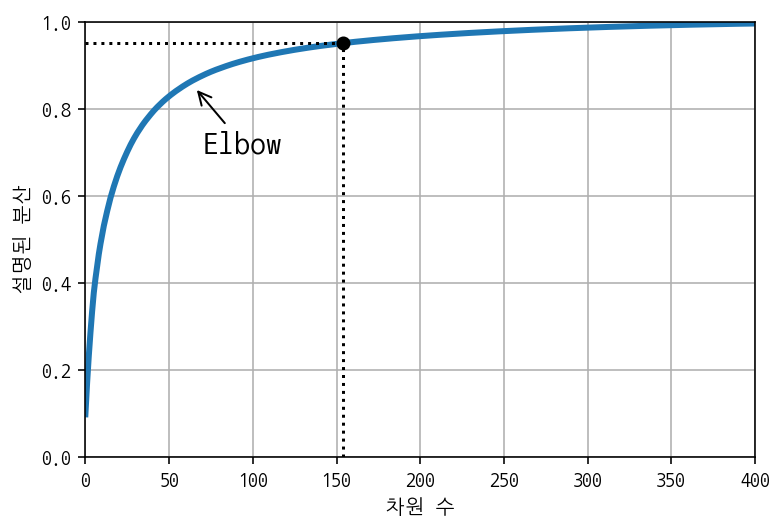

In [12]:
# 설명된 분산을 차원 수에 대한 함수로 그린다.
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothicCoding')
plt.rc('axes', unicode_minus=False) 
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3) # 그냥 cumsum 그리면 된다!
plt.axis([0, 400, 0, 1])
plt.xlabel("차원 수")
plt.ylabel("설명된 분산")
plt.plot([d, d], [0, 0.95], "k:") # 세로점선
plt.plot([0, d], [0.95, 0.95], "k:") # 가로점선
plt.plot(d, 0.95, "ko") #point dot
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## 8.3.7 압축을 위한 PCA

- **재구성 오차**(reconstruction error) : 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리

In [17]:
# MNIST 데이터셋을 inverse_transform() 으로 재구성
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [18]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

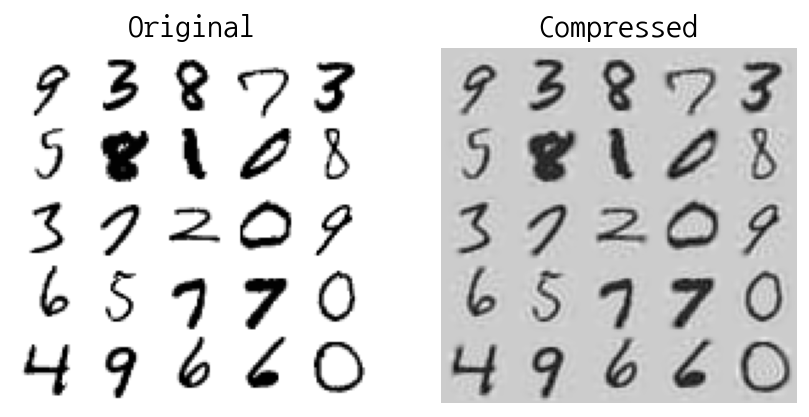

In [20]:
import matplotlib as mpl

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("C:\\Users\\sarah\\Documents\\mnist_image.png", format="png", dpi=300)

# 그림이 왜 교재랑 다르게 나오지??? ㅠㅠㅠ

## 8.3.8 랜덤 PCA

In [16]:
# randomized PCA, 차원을 많이 줄일수록 계산복잡도가 훨씬 줄어든다.
rnd_pca = PCA(n_components=154, svd_solver="randomized") # solver 기본값은 auto
X_reduced = rnd_pca.fit_transform(X_train)

## 8.3.9 점진적 PCA

- **점진적 PCA**(incremental PCA, IPCA) : 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입하는 방식.
훈련 세트가 클 때 유용.

In [21]:
# MNIST 데이터셋을 미니배치로 나누기
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches) :
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [24]:
# memmap python class 이용
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [25]:
# 잘 저장되었는지 확인하기 위해 객체를 삭제
del X_mm

In [26]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

# 8.4 커널 PCA

- **커널 PCA**(kernel PCA, kPCA) : 차원 축소를 위한 복잡한 비선형 투형.

In [27]:
# RBF 커널로 kPCA 적용하기
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64